# Is it possible to predict stock market?
<div style="text-align:center;">
    <img src="img/img_gpw_1.jpg" alt="gpw" width="500"/>
</div>

# In this project I will:
* download from yahoo module and proccess data for WIG20 and others
* analyze basic attributes of index
* look for correlated indecies, commodities, currencies
* use deep learning models like prohpety to predict stock market
* I will also check out the LSTM recurrent neural network model to try to predict the stock markets

# 1. **Introductions in the stock markets**
The stock market, is a dynamic environment where investors purchase and sell shares and other financial instruments. The prices of these assets fluctuate constantly depending on daily trading activity and the impact of global events. Predicting these movements is extremely difficult because of the multitude of factors such as economic data, political decisions, corporate earnings and investor psychology.
Additionally, global money flows play an important role by linking different markets into groups, such as emerging markets and developed markets. The movement of capital between regions of the world affected by local wars affect as well. These complex relationships and global capital flows make stock market analysis an even more fascinating challenge.
# 2. **Collecting data**
The process of collecting data in stock markets is a key step in analysis and modeling. Investors and financial analysts use a variety of data sources such as financial API, market data providers and publicly available sources to obtain information about stock prices, stock indices, commodities and currencies.
8In this project, I will utilize Yahoo Finance, which provides free access for personal use only, allowing up to a total of 48,000 requests per day. This is likely one of the best free solutions available at the moment.

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

from prophet import Prophet

symbols = pd.read_csv("tickers_symbols.csv")
tickers_list = symbols["ticker"].tolist()

In [2]:
df = yf.download(tickers_list, start="2020-01-01")
df = df["Adj Close"]

[*********************100%***********************]  132 of 132 completed


In [3]:
symbols = symbols.set_index('ticker')['name']

In [4]:
print(df.isnull().sum())

000001.SS    469
399001.SZ    469
6A=F         432
6B=F         431
6C=F         431
            ... 
^TNX         431
^TWII        467
^TYX         431
^VIX         431
^XAX         431
Length: 132, dtype: int64


In [5]:
percentage_missing = (df.isnull().sum() / len(df)) * 100
percentage_missing = percentage_missing.sort_values(ascending=False)
print(percentage_missing)

OJ=F         61.616162
ETH=F        51.082251
LBS=F        38.816739
000001.SS    33.838384
399001.SZ    33.838384
               ...    
IDR=X        28.571429
INR=X        28.571429
JPY=X        28.571429
ETH-USD       0.000000
BTC-USD       0.000000
Length: 132, dtype: float64


In [6]:
threshold = 40  # Percentage threshold
columns_to_drop = percentage_missing[percentage_missing > threshold].index
df=df.drop(columns=columns_to_drop)

In [7]:
df.ffill(inplace=True)
print("Left null values: ",df.isnull().any().sum())
df.dropna(inplace=True)
print("Left null values: ",df.isnull().any().sum())

Left null values:  101
Left null values:  0


In [8]:
df_pct = df.pct_change().dropna()*100

In [9]:
std_dev=df_pct.std()

print("Lowest daily variability")
lowest_std=std_dev.nsmallest(10)
print(lowest_std)

print("higest daily variability")
highest_std=std_dev.nlargest(10)
print(highest_std)

Lowest daily variability
HKD=X       0.034367
ZQ=F        0.045625
ZT=F        0.099204
ZF=F        0.229998
SGD=X       0.243818
MYR=X       0.255102
EURCHF=X    0.275738
CNY=X       0.295467
INR=X       0.317324
ZN=F        0.337131
dtype: float64
higest daily variability
^MERV      51.529688
RUB=X      38.806959
^IRX       32.480828
CL=F        9.446693
^VIX        6.865819
ETH-USD     4.623608
^FVX        4.530579
NG=F        4.010878
^TNX        3.677723
BTC-USD     3.529061
dtype: float64


Invest in highly volatile indices with caution. But the lowest ones are also not suitable for making good returns.

In [10]:
print("The lowest variability:")
for idx, row in lowest_std.reset_index().iterrows():
    print("\t",idx+1,row.iloc[0],symbols[row.iloc[0]],"-",round(row.iloc[1],4))

The lowest variability:
	 1 HKD=X USD/HKD - 0.0344
	 2 ZQ=F 30 Day Fed Fund - 0.0456
	 3 ZT=F 2-Year T-Note Futures,Dec-2023 - 0.0992
	 4 ZF=F Five-Year US Treasury Note Futu - 0.23
	 5 SGD=X USD/SGD - 0.2438
	 6 MYR=X USD/MYR - 0.2551
	 7 EURCHF=X EUR/CHF - 0.2757
	 8 CNY=X USD/CNY - 0.2955
	 9 INR=X USD/INR - 0.3173
	 10 ZN=F 10-Year T-Note Futures,Dec-2023 - 0.3371


In [11]:
print("The highest variability:")
for idx, row in highest_std.reset_index().iterrows():
    print("\t",idx+1,row.iloc[0],symbols[row.iloc[0]],"-",round(row.iloc[1],4))

The highest variability:
	 1 ^MERV MERVAL - 51.5297
	 2 RUB=X USD/RUB - 38.807
	 3 ^IRX 13 WEEK TREASURY BILL - 32.4808
	 4 CL=F Crude Oil - 9.4467
	 5 ^VIX CBOE VIX Futures - 6.8658
	 6 ETH-USD Ethereum USD - 4.6236
	 7 ^FVX Treasury Yield 5 Years - 4.5306
	 8 NG=F Natural Gas Nov 23 - 4.0109
	 9 ^TNX Treasury Yield 10 Years - 3.6777
	 10 BTC-USD Bitcoin USD - 3.5291


In [12]:
first_price = df.iloc[0]
last_price = df.iloc[-1]
returns = (last_price / first_price - 1) * 100
top_10_returns = returns.nlargest(10)
bottom_10_returns = returns.nsmallest(10)

print("The highest return:")
idx=0
for ticker,profit in top_10_returns.items():
    idx+=1
    print("\t",idx,profit," - ",symbols[ticker],ticker)

print("The lowest return:")
idx=0
for ticker,profit in bottom_10_returns.items():
    idx+=1
    print("\t",idx,profit," - ",symbols[ticker],ticker)
    

The highest return:
	 1 1734.2882317219  -  MERVAL ^MERV
	 2 980.7874746606179  -  Ethereum USD ETH-USD
	 3 265.77180292748056  -  Bitcoin USD BTC-USD
	 4 258.87096948634814  -  13 WEEK TREASURY BILL ^IRX
	 5 202.66915602705836  -  Treasury Yield 5 Years ^FVX
	 6 167.53176670866966  -  Treasury Yield 10 Years ^TNX
	 7 116.96626821181981  -  Treasury Yield 30 Years ^TYX
	 8 100.21850464417876  -  Sugar #11 Mar 24 SB=F
	 9 83.94287303338024  -  S&P Information Technology ^SP500-45
	 10 79.92745692028862  -  NYSE AMEX COMPOSITE INDEX ^XAX
The lowest return:
	 1 -98.73429580075268  -  Rough Rice Futures,Jan-2024 ZR=F
	 2 -42.69629104203093  -  Palladium Dec 23 PA=F
	 3 -37.03245040119199  -  HANG SENG INDEX ^HSI
	 4 -33.47288545160375  -  iShares 20+ Year Treasury Bond ETF (TLT)  TLT
	 5 -30.35656678607477  -  iShares MSCI China ETF MCHI
	 6 -30.271233419124922  -  U.S. Treasury Bond Futures,Dec- ZB=F
	 7 -27.8990251643755  -  Yapanese Yen JPYUSD=X
	 8 -17.819148936170215  -  10-Year T-Not

In [13]:
df.ffill(inplace=True)
print(df.isnull().any().sum())
df.dropna(inplace=True)
print(df.isnull().any().sum())

0
0


In [14]:
corr_matrix = df.corr()
corr_epol=corr_matrix["EPOL"].sort_values(ascending=False)

In [15]:
top_corr=corr_epol[1:11]
bottom_corr=corr_epol[-10:]
bottom_corr=bottom_corr[::-1]

In [16]:
print("Top positive correlated:")
print(top_corr)

print("Top negative correlated:")
print(bottom_corr)

Top positive correlated:
IMOEX.ME    0.857922
6B=F        0.822573
GBPUSD=X    0.817557
CZK=F       0.808459
EFA         0.791095
EEM         0.753320
^NZ50       0.736900
MME=F       0.735679
^KS11       0.721498
^IXIC       0.716556
Name: EPOL, dtype: float64
Top negative correlated:
SGD=X      -0.653476
DX-Y.NYB   -0.645748
CHF=X      -0.609246
^VIX       -0.588948
IDR=X      -0.553877
EURHUF=X   -0.549783
ZAR=X      -0.515347
CNY=X      -0.512839
MYR=X      -0.450283
PHP=X      -0.446767
Name: EPOL, dtype: float64


In [17]:
print("The highest correlation:")
idx=0
for ticker,profit in top_corr.items():
    idx+=1
    print("\t",idx,round(profit,4)," - ",symbols[ticker],ticker)

print("The lowest correlation:")
idx=0
for ticker,profit in bottom_corr.items():
    idx+=1
    print("\t",idx,round(profit,4)," - ",symbols[ticker],ticker)

The highest correlation:
	 1 0.8579  -  MOEX Russia Index IMOEX.ME
	 2 0.8226  -  British Pound 6B=F
	 3 0.8176  -  GBP/USD GBPUSD=X
	 4 0.8085  -  Czech Koruna Futures,Dec-2023 CZK=F
	 5 0.7911  -  iShares MSCI EAFE ETF EFA
	 6 0.7533  -  iShares MSCI Emerging Markets ETF EEM
	 7 0.7369  -  S&P/NZX 50 INDEX GROSS  ^NZ50
	 8 0.7357  -  MSCI Emerging Markets Index Futures MME=F
	 9 0.7215  -  KOSPI Composite Index ^KS11
	 10 0.7166  -  NASDAQ Composite ^IXIC
The lowest correlation:
	 1 -0.6535  -  USD/SGD SGD=X
	 2 -0.6457  -  USD Index DX-Y.NYB
	 3 -0.6092  -  Swiss Franc CHF=X
	 4 -0.5889  -  CBOE VIX Futures ^VIX
	 5 -0.5539  -  USD/IDR IDR=X
	 6 -0.5498  -  EUR/HUF EURHUF=X
	 7 -0.5153  -  USD/ZAR ZAR=X
	 8 -0.5128  -  USD/CNY CNY=X
	 9 -0.4503  -  USD/MYR MYR=X
	 10 -0.4468  -  USD/PHP PHP=X


The most pronounced correlation is observed between EPOL and the EUR/USD exchange rate. This relationship is justified, considering that capital tends to flow into Poland when the Polish index records increases, elsewhere there are etf iShares MSCI EAFE ETF (MSCI Europe, Australasia and the Far East), European currencies such as the Euro/Dolar, British Pound, Czech Koruna, over American Index SP500 – the American index is the most influential market index in the world, and others are related to our market index through geographical proximity or market similars.

On the other hand, the most negatively correlated indices, with correlation coefficients below -0.6, include the U.S. Dollar, the Hungarian Forint/Euro, the Swiss Franc, and other currencies in relation to the Dollar. This indicates the strength of these currencies and their role as a safe haven during times of risk in contrast to the more volatile Polish emerging markets.

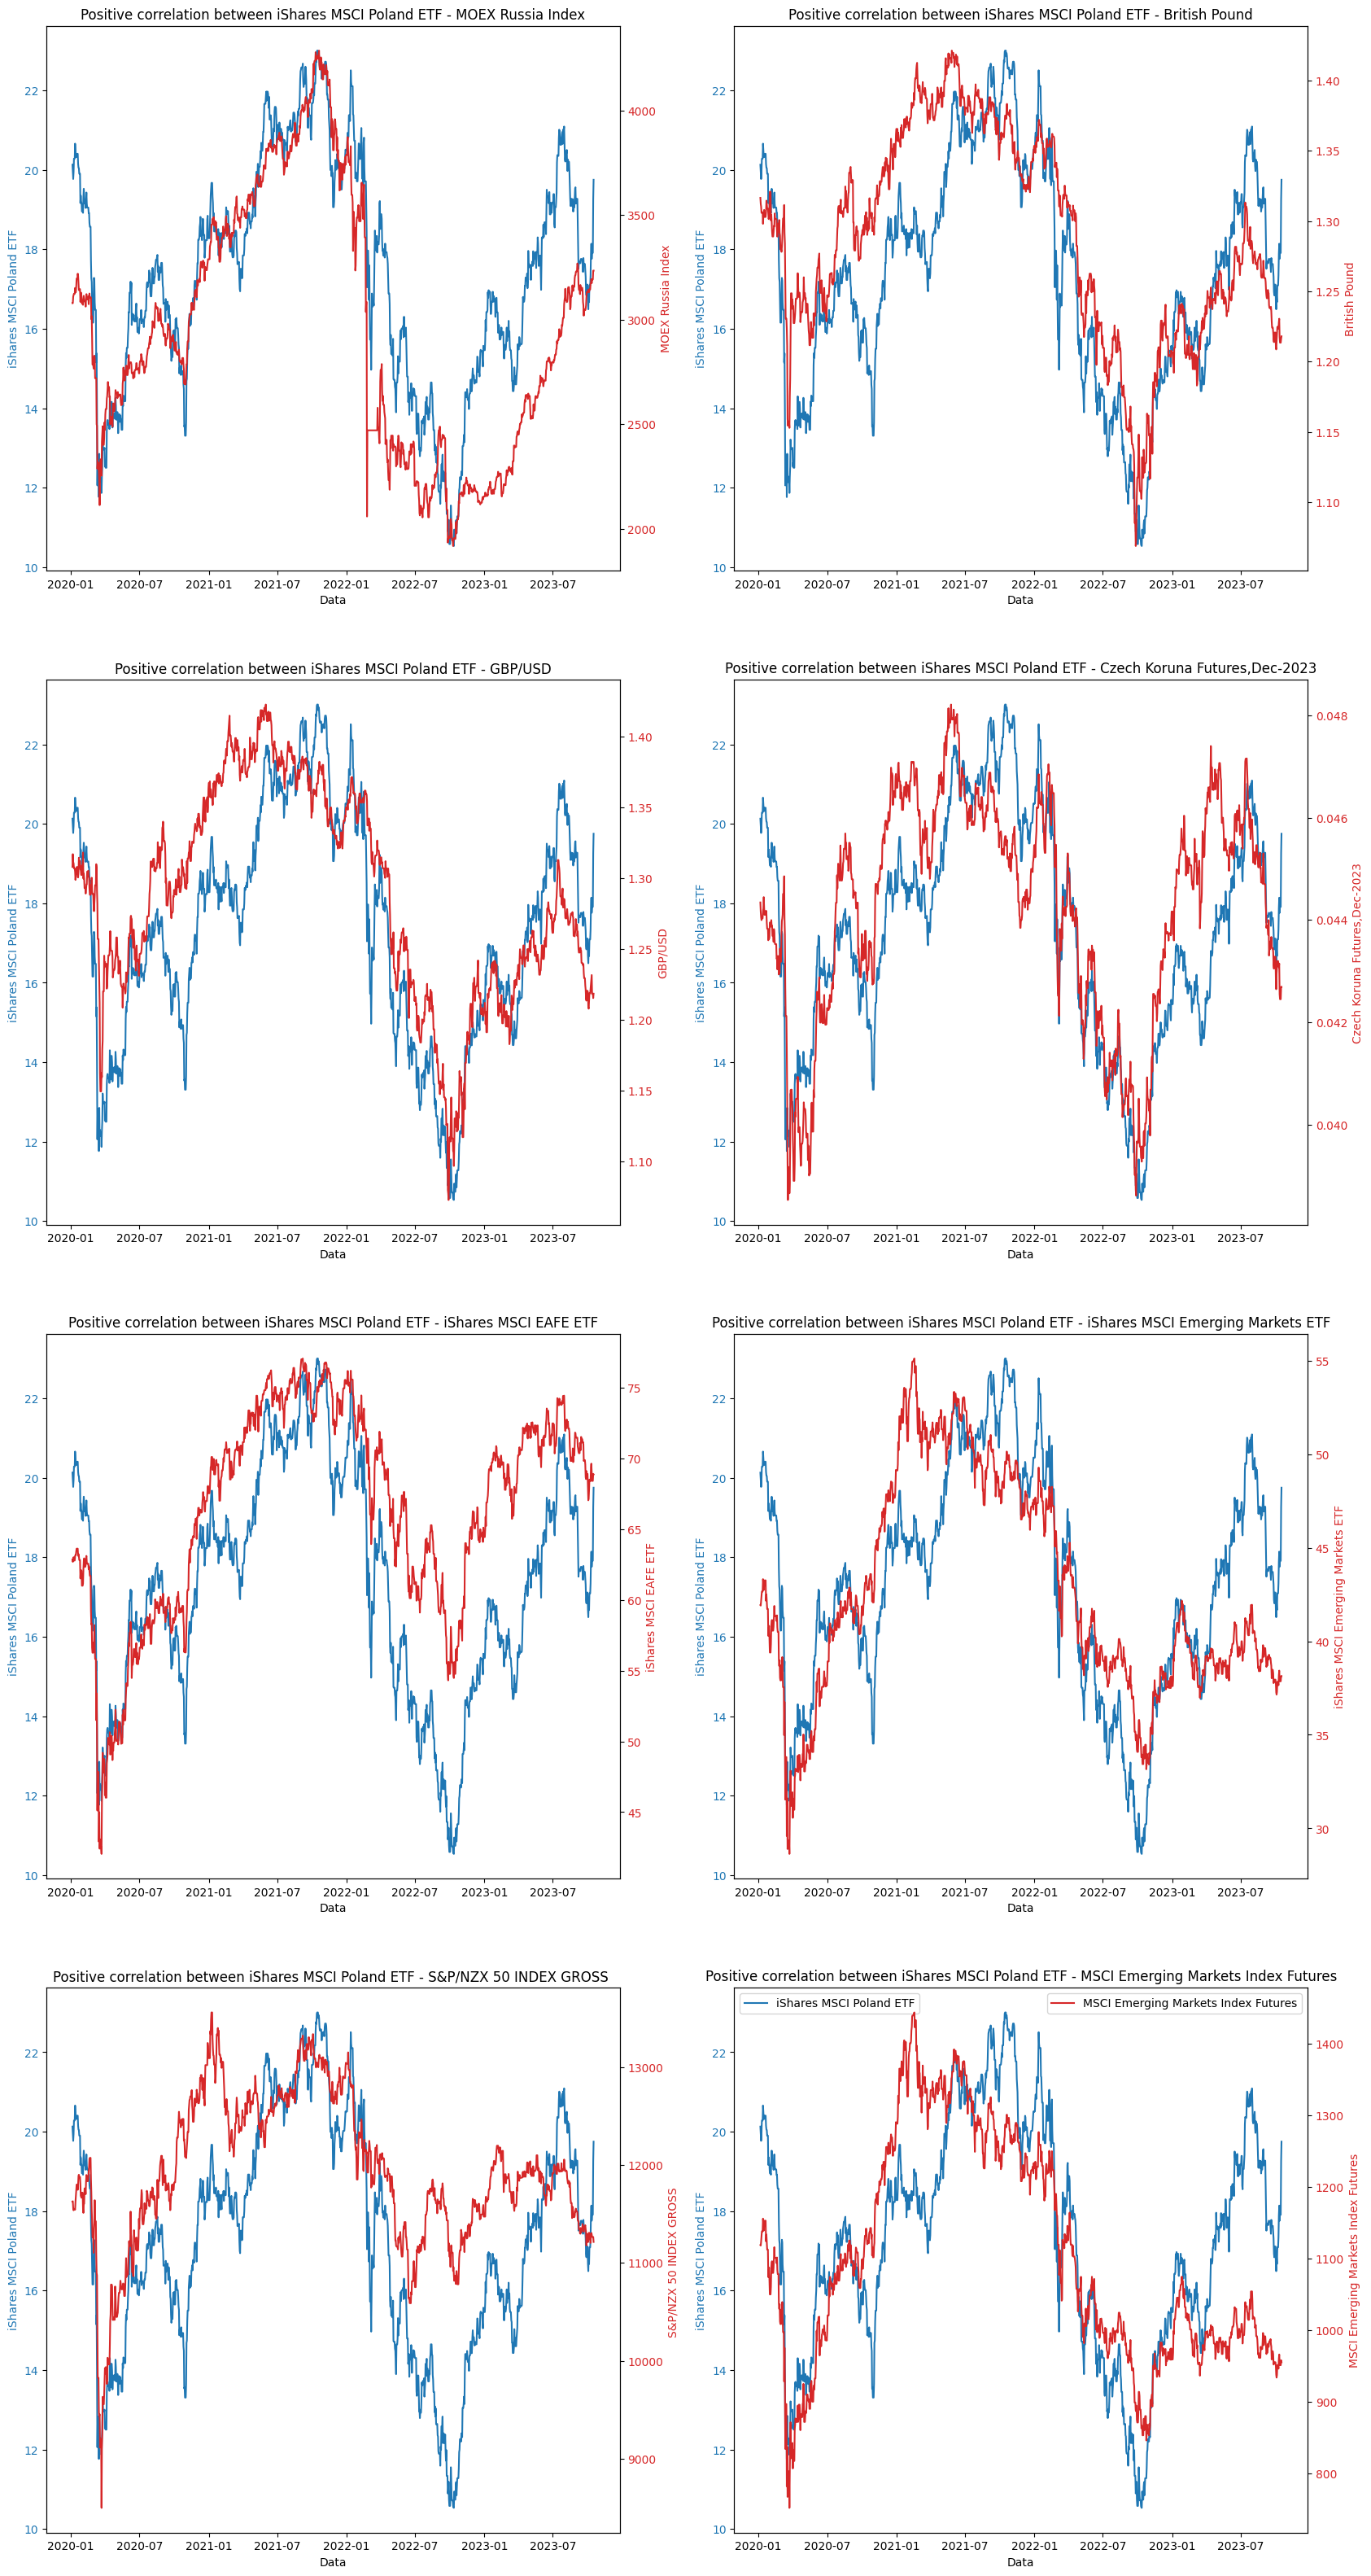

In [18]:
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(20, 40))

# Iterate through your symbols
for i, symbol in enumerate(top_corr[:8].index):
    # Determine the current subplot position in the grid
    row = i // 2
    col = i % 2

    # Select the current subplot
    ax1 = ax[row, col]

    # First chart (blue line)
    ax1.set_xlabel('Data')
    ax1.set_ylabel(symbols["EPOL"], color='tab:blue')
    ax1.plot(df.index, df["EPOL"], color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    # Create a second axis for the second chart (red line)
    ax2 = ax1.twinx()

    # Second chart (red line)
    ax2.set_ylabel(symbols[symbol], color='tab:red')
    ax2.plot(df.index, df[symbol], color='tab:red')
    ax2.tick_params(axis='y', labelcolor='tab:red')

    # Set the title for the subplot
    ax1.set_title(f'Positive correlation between {symbols["EPOL"]} - {symbols[symbol]}')

# You might want to add legends outside of the loop

# Add legend for the blue line
ax1.legend([symbols["EPOL"]], loc='upper left')

# Add legend for the red line
ax2.legend([symbols[symbol]], loc='upper right')

# Display the entire figure (all subplots)
plt.show()

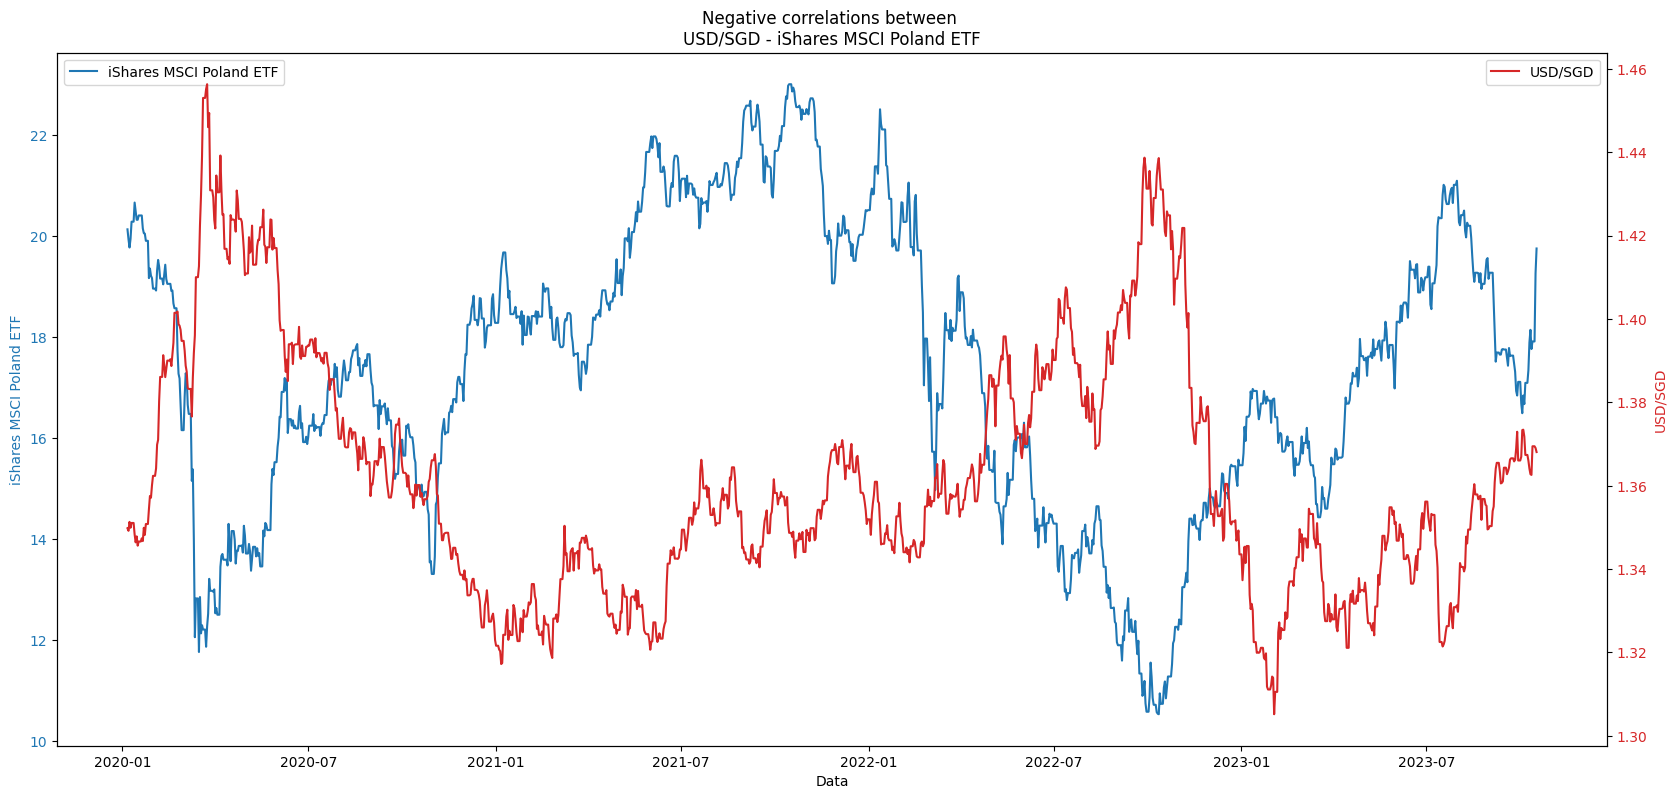

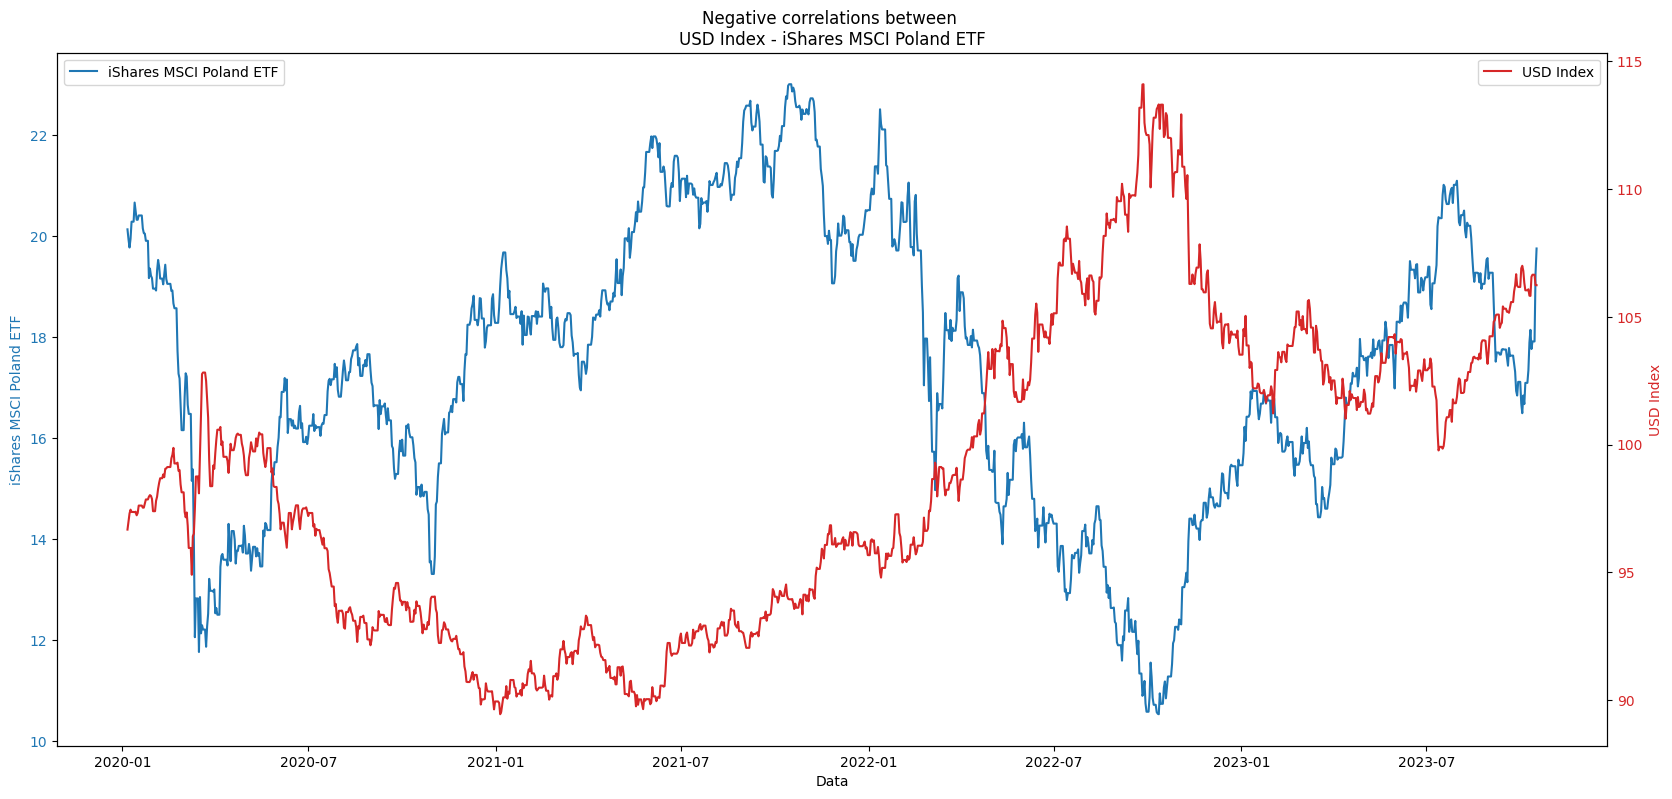

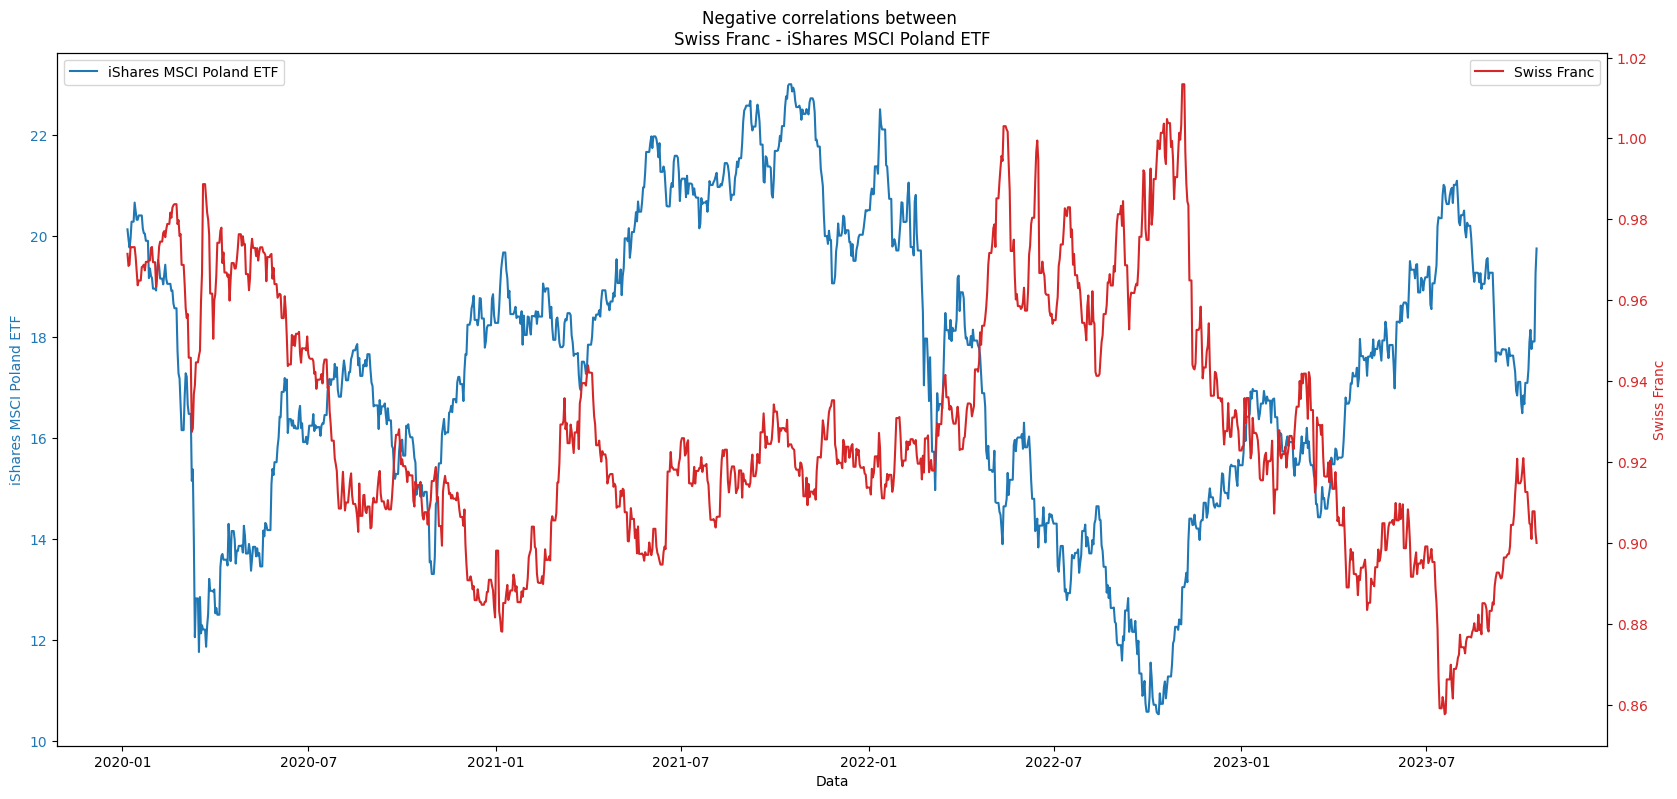

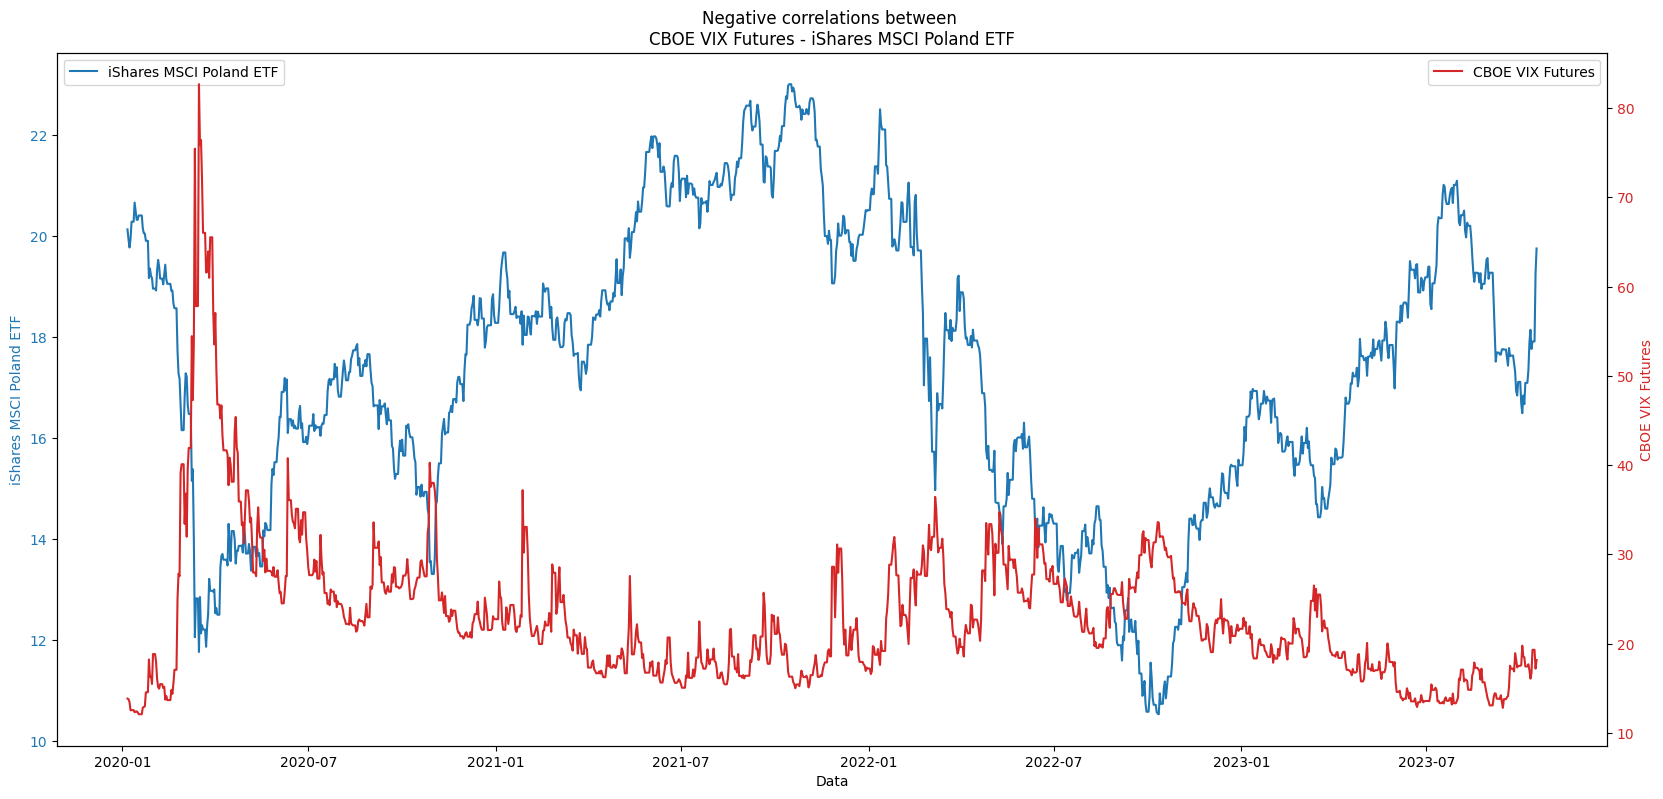

In [19]:
for symbol in bottom_corr[:4].index:
    fig, ax1 = plt.subplots(figsize=(20, 9))
    
    # chart for first symbol
    color = 'tab:blue'
    ax1.set_xlabel('Data')
    ax1.set_ylabel(symbols["EPOL"], color=color)
    ax1.plot(df.index, df["EPOL"], color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    
    #second axis
    ax2 = ax1.twinx()
    
    # second chart
    color = 'tab:red'
    ax2.set_ylabel(symbols[symbol], color=color)
    ax2.plot(df.index, df[symbol], color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    
    plt.title(f'Negative correlations between \n{symbols[symbol]} - {symbols["EPOL"]}')
    
    # legend
    ax1.legend([symbols["EPOL"]], loc='upper left')
    ax2.legend([symbols[symbol]], loc='upper right')
    
    plt.show()

The dollar is one of the most negatively correlated indices with all types of shares, especially WIG20 as emergin market.

In [20]:
epol_df = yf.download("EPOL")["Adj Close"].to_frame(name="EPOL")

[*********************100%***********************]  1 of 1 completed


In [21]:
print(epol_df.isnull().any().sum())
epol_df = epol_df.ffill()
epol_df=epol_df.dropna()

0


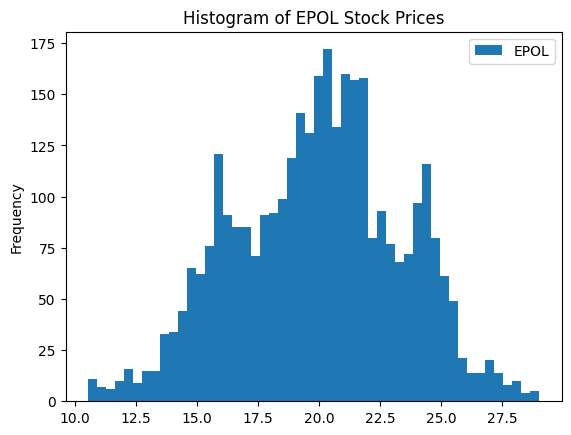

In [22]:
# Create a histogram with 50 bins for the 'EPOL' column
epol_df.plot(kind='hist', bins=50)

# Set a title for the plot
plt.title('Histogram of EPOL Stock Prices')

# Display the plot
plt.show()


We can see how prices are distributed, mainly around 20, and interestingly, big peaks appear around 24 and 16 (this could be border for over and under - valuation of the stock exchange)

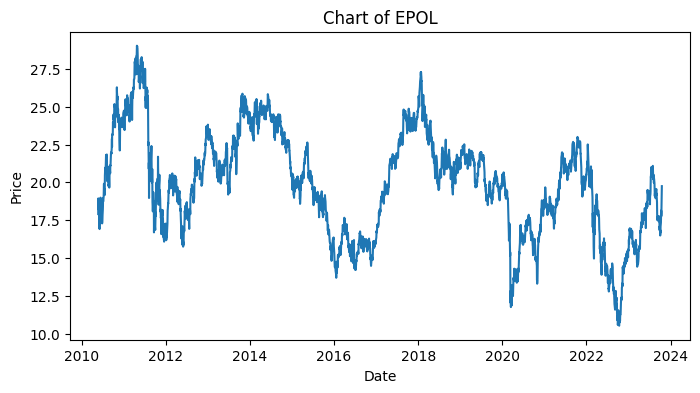

In [23]:
plt.figure(figsize=(8, 4))
plt.plot(epol_df)
plt.title('Chart of EPOL')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [24]:
last_price=epol_df.iloc[-1,0]
print("last price: ",last_price)

last price:  19.75


It's fair to say we are cheap now, last price is below common value (17.91$)

In [25]:
epol_df.describe()

,EPOL
count,3372.000000
mean,19.959731
std,3.426406
min,10.531733
25%,17.470480
50%,20.141602
75%,22.269663
max,29.024199


Based on this information, the latest value of 17.9 is lower than the mean 19.96 and median 20.14.
It is also below the third quartile (75%) of 22.27 and above the first quartile (25%) of 17.47. This means that price in the last observation is at a level that is between the lower and upper halves of the data in the price distribution. 
That also suggest for that the EPOL share price is currently at a relatively lower level compared to the average or higher price level over the period analyzed.

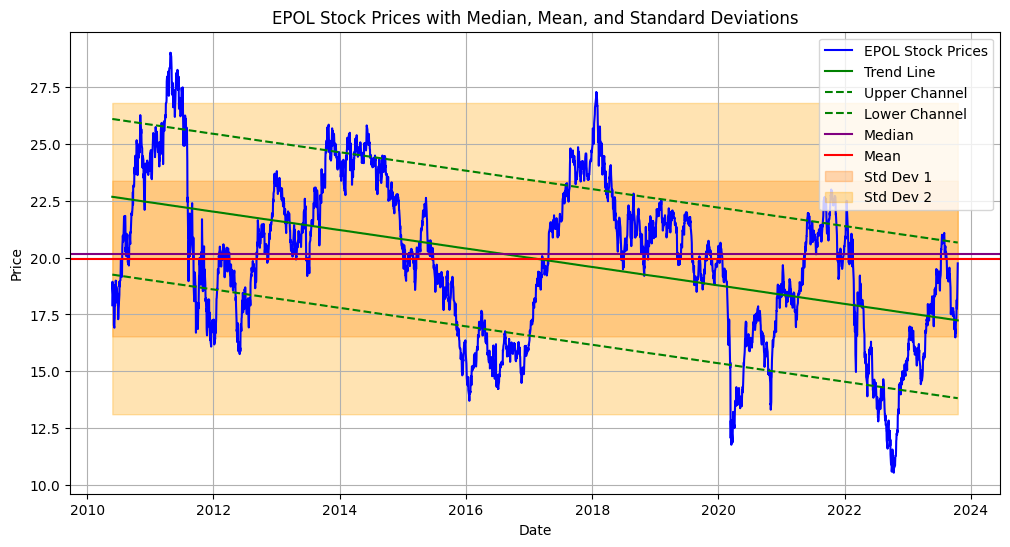

In [26]:
median = epol_df.median()[0]
mean = epol_df.mean()[0]
std_dev = epol_df.std()[0]
std_dev_1 = std_dev
std_dev_2 = 2 * std_dev

prices = epol_df.values.reshape(-1, 1)
dates = np.arange(len(epol_df)).reshape(-1, 1)


model = LinearRegression()
model.fit(dates, prices)

trend_line = model.predict(dates)
channel_width =  std_dev
upper_channel = trend_line + channel_width
lower_channel = trend_line - channel_width

# making chart
plt.figure(figsize=(12, 6))
plt.plot(epol_df.index, epol_df, label='EPOL Stock Prices', color='blue')
plt.plot(epol_df.index, trend_line, label='Trend Line', color='green')
# Add upper and lower channel lines to the plot
plt.plot(epol_df.index, upper_channel, label='Upper Channel', color='green', linestyle='--')
plt.plot(epol_df.index, lower_channel, label='Lower Channel', color='green', linestyle='--')

plt.axhline(median, linestyle='-', label='Median', color='purple')
plt.axhline(mean, linestyle='-', label='Mean', color='red')
plt.fill_between(epol_df.index, mean - std_dev_1, mean + std_dev_1, alpha=0.3, label='Std Dev 1', color='tab:orange')
plt.fill_between(epol_df.index, mean - std_dev_2, mean + std_dev_2, alpha=0.3, label='Std Dev 2', color='orange')

plt.title('EPOL Stock Prices with Median, Mean, and Standard Deviations')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


Data based on regression with a one standard deviation channel show a long-term downward trend

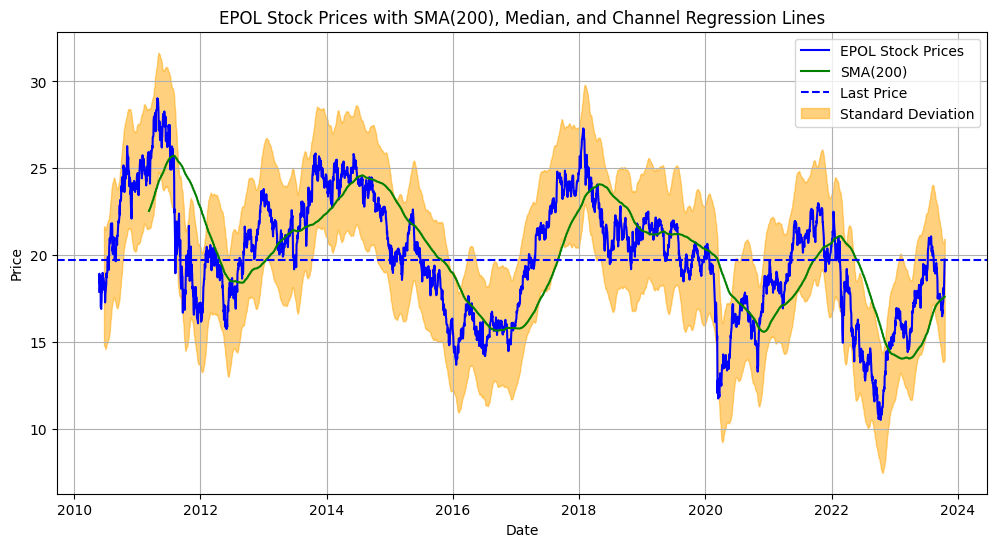

In [27]:
sma200 = epol_df["EPOL"].rolling(window=200).mean()
sma20=epol_df['EPOL'].rolling(window=20).mean()
# Rest of your code remains the same
plt.figure(figsize=(12, 6))
plt.plot(epol_df.index, epol_df["EPOL"], label='EPOL Stock Prices', color='blue')
plt.plot(epol_df.index, sma200, label='SMA(200)', color='green')
plt.axhline(last_price, linestyle='--', label='Last Price' ,color='blue')
plt.fill_between(epol_df.index, sma20 - std_dev, sma20 + std_dev, alpha=0.5, label='Standard Deviation', color='orange')
plt.title('EPOL Stock Prices with SMA(200), Median, and Channel Regression Lines')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


The 200-day moving average is a long-term trend-following indicator that helps identify the overall direction. Now price of index is above 200-day moving average which tell as obout upside trend and momentum.

Bollinger Bands consist of typically a 20-period simple moving average and outer bands, which are one standard deviations above and below the sma.
When the price of a security touches or crosses the upper Bollinger Band, it may suggest that the asset is overbought, indicating a potential reversal or pullback. Conversely, when the price touches or crosses the lower band, it may signal oversold conditions, suggesting a possible upward price correction. So it's not time to buy now.

21:11:40 - cmdstanpy - INFO - Chain [1] start processing
21:11:42 - cmdstanpy - INFO - Chain [1] done processing


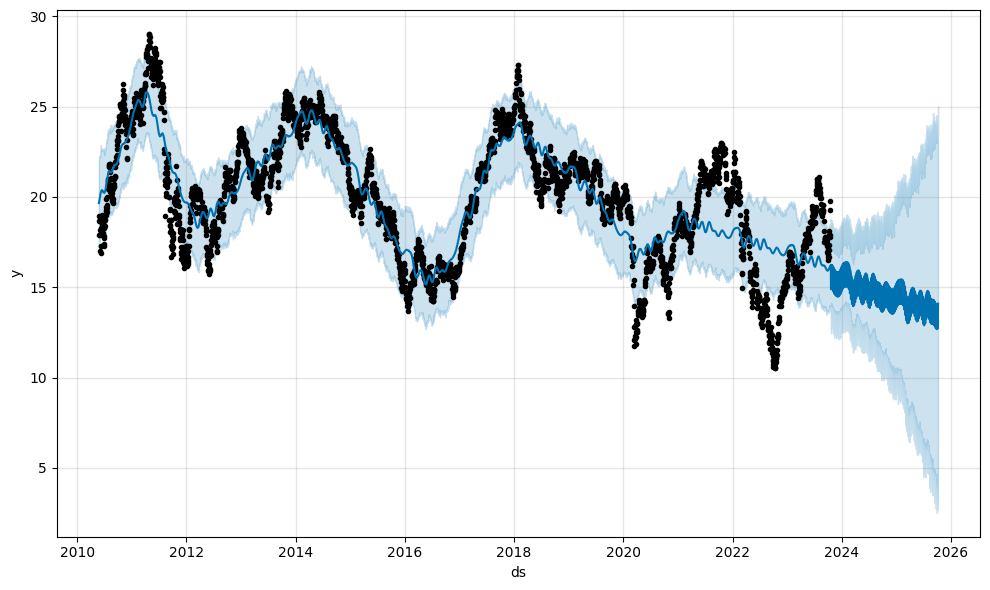

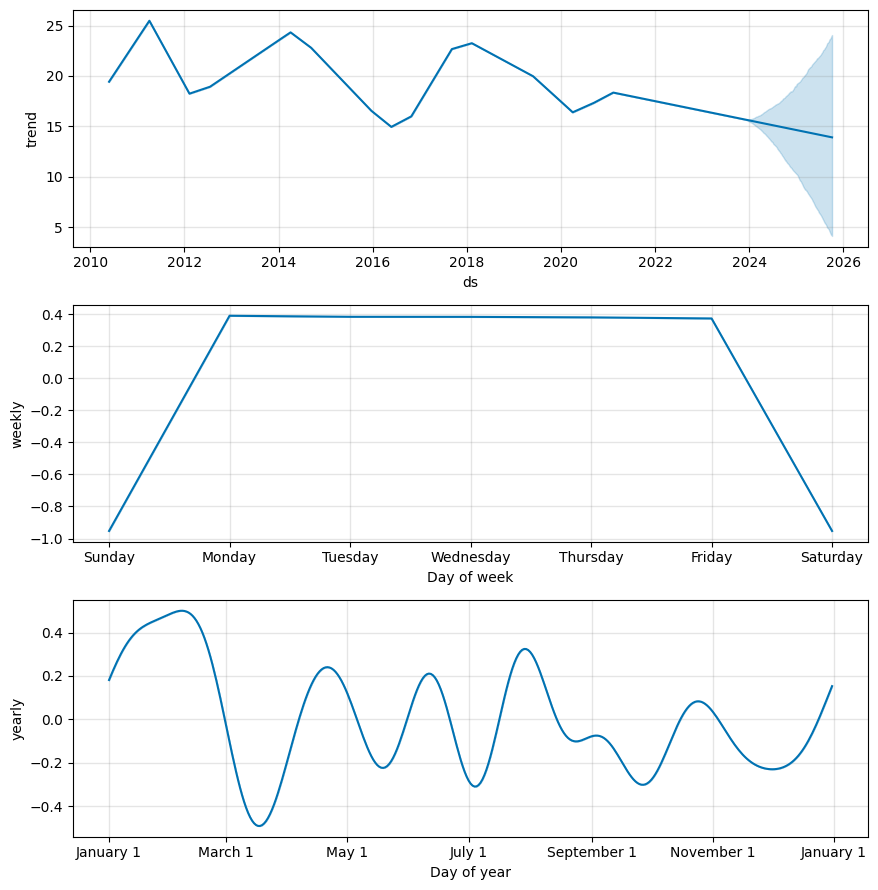

In [28]:
# print(epol_df['EPOL'].values)
data = pd.DataFrame()
data['ds'] = epol_df.index
data['y'] = epol_df['EPOL'].values # Assuming the index contains date information
# Create a Prophet model
model = Prophet()

# Fit the model
model.fit(data)

# Create a dataframe for future predictions
future = model.make_future_dataframe(periods=720)  # You can change the number of days you want to forecast

# Make predictions
forecast = model.predict(future)


# To visualize the forecast, you can use the following code
fig = model.plot(forecast)

# To see the components of the forecast, you can use the following code
fig = model.plot_components(forecast)


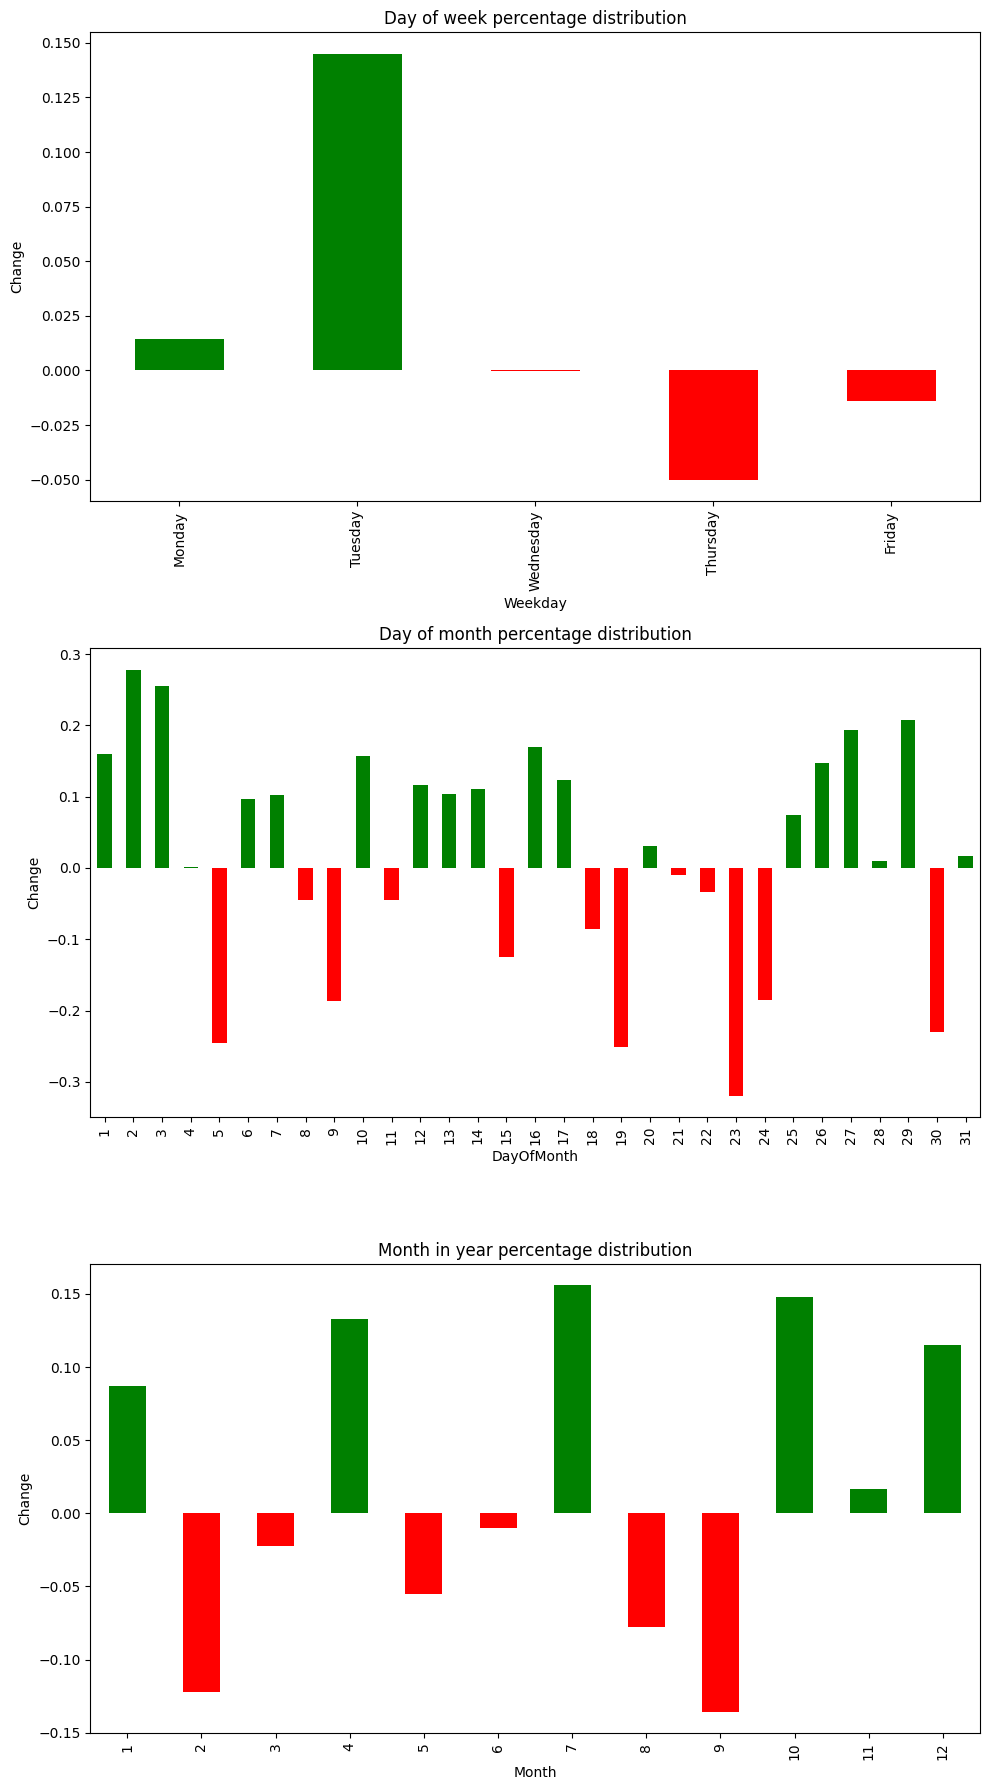

In [29]:
epol_df_pct = epol_df.pct_change().dropna() * 100
epol_df_pct["Weekday"] = epol_df_pct.index.day_name()
epol_df_pct["DayOfMonth"] = epol_df_pct.index.day
epol_df_pct["Month"] = epol_df_pct.index.month

fig, axs = plt.subplots(3, 1, figsize=(10, 18))

average_day_of_week_pct = epol_df_pct.groupby("Weekday")["EPOL"].mean().reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'])
average_day_of_month_pct = epol_df_pct.groupby("DayOfMonth")["EPOL"].mean()
average_month_pct = epol_df_pct.groupby("Month")["EPOL"].mean()

def plot_average(data, title, ax):
    data.plot(kind='bar', color=['g' if val >= 0 else 'r' for val in data], ax=ax)
    ax.set_title(title)
    ax.set_ylabel('Change')

plot_average(average_day_of_week_pct, 'Day of week percentage distribution', axs[0])
plot_average(average_day_of_month_pct, 'Day of month percentage distribution', axs[1])
plot_average(average_month_pct, 'Month in year percentage distribution', axs[2])

plt.tight_layout() 
plt.show()

The best time for Polish shares is at the beginning of the week with the highest rate of return falls on Tuesday.

Remember not to invest before September and February! - These are the worst months for Polish shares.

This early autumn falls is well-known world phenomena that often appears in September when investors came from holidays.
Other known rules that apears here, "sell in May and go away", January Effects and Santa Claus Rally in December.

Index's conclusion:
- The Polish WIG20 stock index, as an index of emerging countries, was most influenced by the dollar index, changes in the PLN exchange rate, EUR/USD exchange rate and the British pound.
- It tends to move with similar indices, such as the Russian Moex, the Czech koruna, as well as the most influential American index SP500 or Dow Jones.
- It changes with some seasonality, with periods of overvaluation and undervaluation, tending to the average.
- Currently, it has short-term upward momentum, but in the long term it is in a slight downward trend.
- Best time to invest is the end of week, best time to sell in Tuesday. 
- Most probably bottoms will appear around August/September and Febrary/March, May/June.
- Best months for Polish stocks are July followed October, April, and December.